In [1]:
import numpy as np

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 300)

from gradvi.tests import toy_priors, toy_data
from gradvi.models import basis_matrix as gvbm
from gradvi.optimize import moving_average as gvma
from gradvi.inference import Trendfiltering
from gradvi.models import TrendfilteringModel

from mrashpen.utils import R_trendfilter
from mrashpen.inference.mrash_wrapR import MrASHR
from mrashpen.models.mixture_gaussian import emfit

In [2]:
n = 512
x = np.linspace(0, 1, n)
np.random.seed(100)

degree = 0
nknots = 4
strue  = 0.2
knots  = np.linspace(0, 1, nknots+2)[1:-1]

data = toy_data.changepoint_from_bspline(x, knots, strue, degree = degree, 
                        signal = "normal", seed = 100,
                        include_intercept = False)

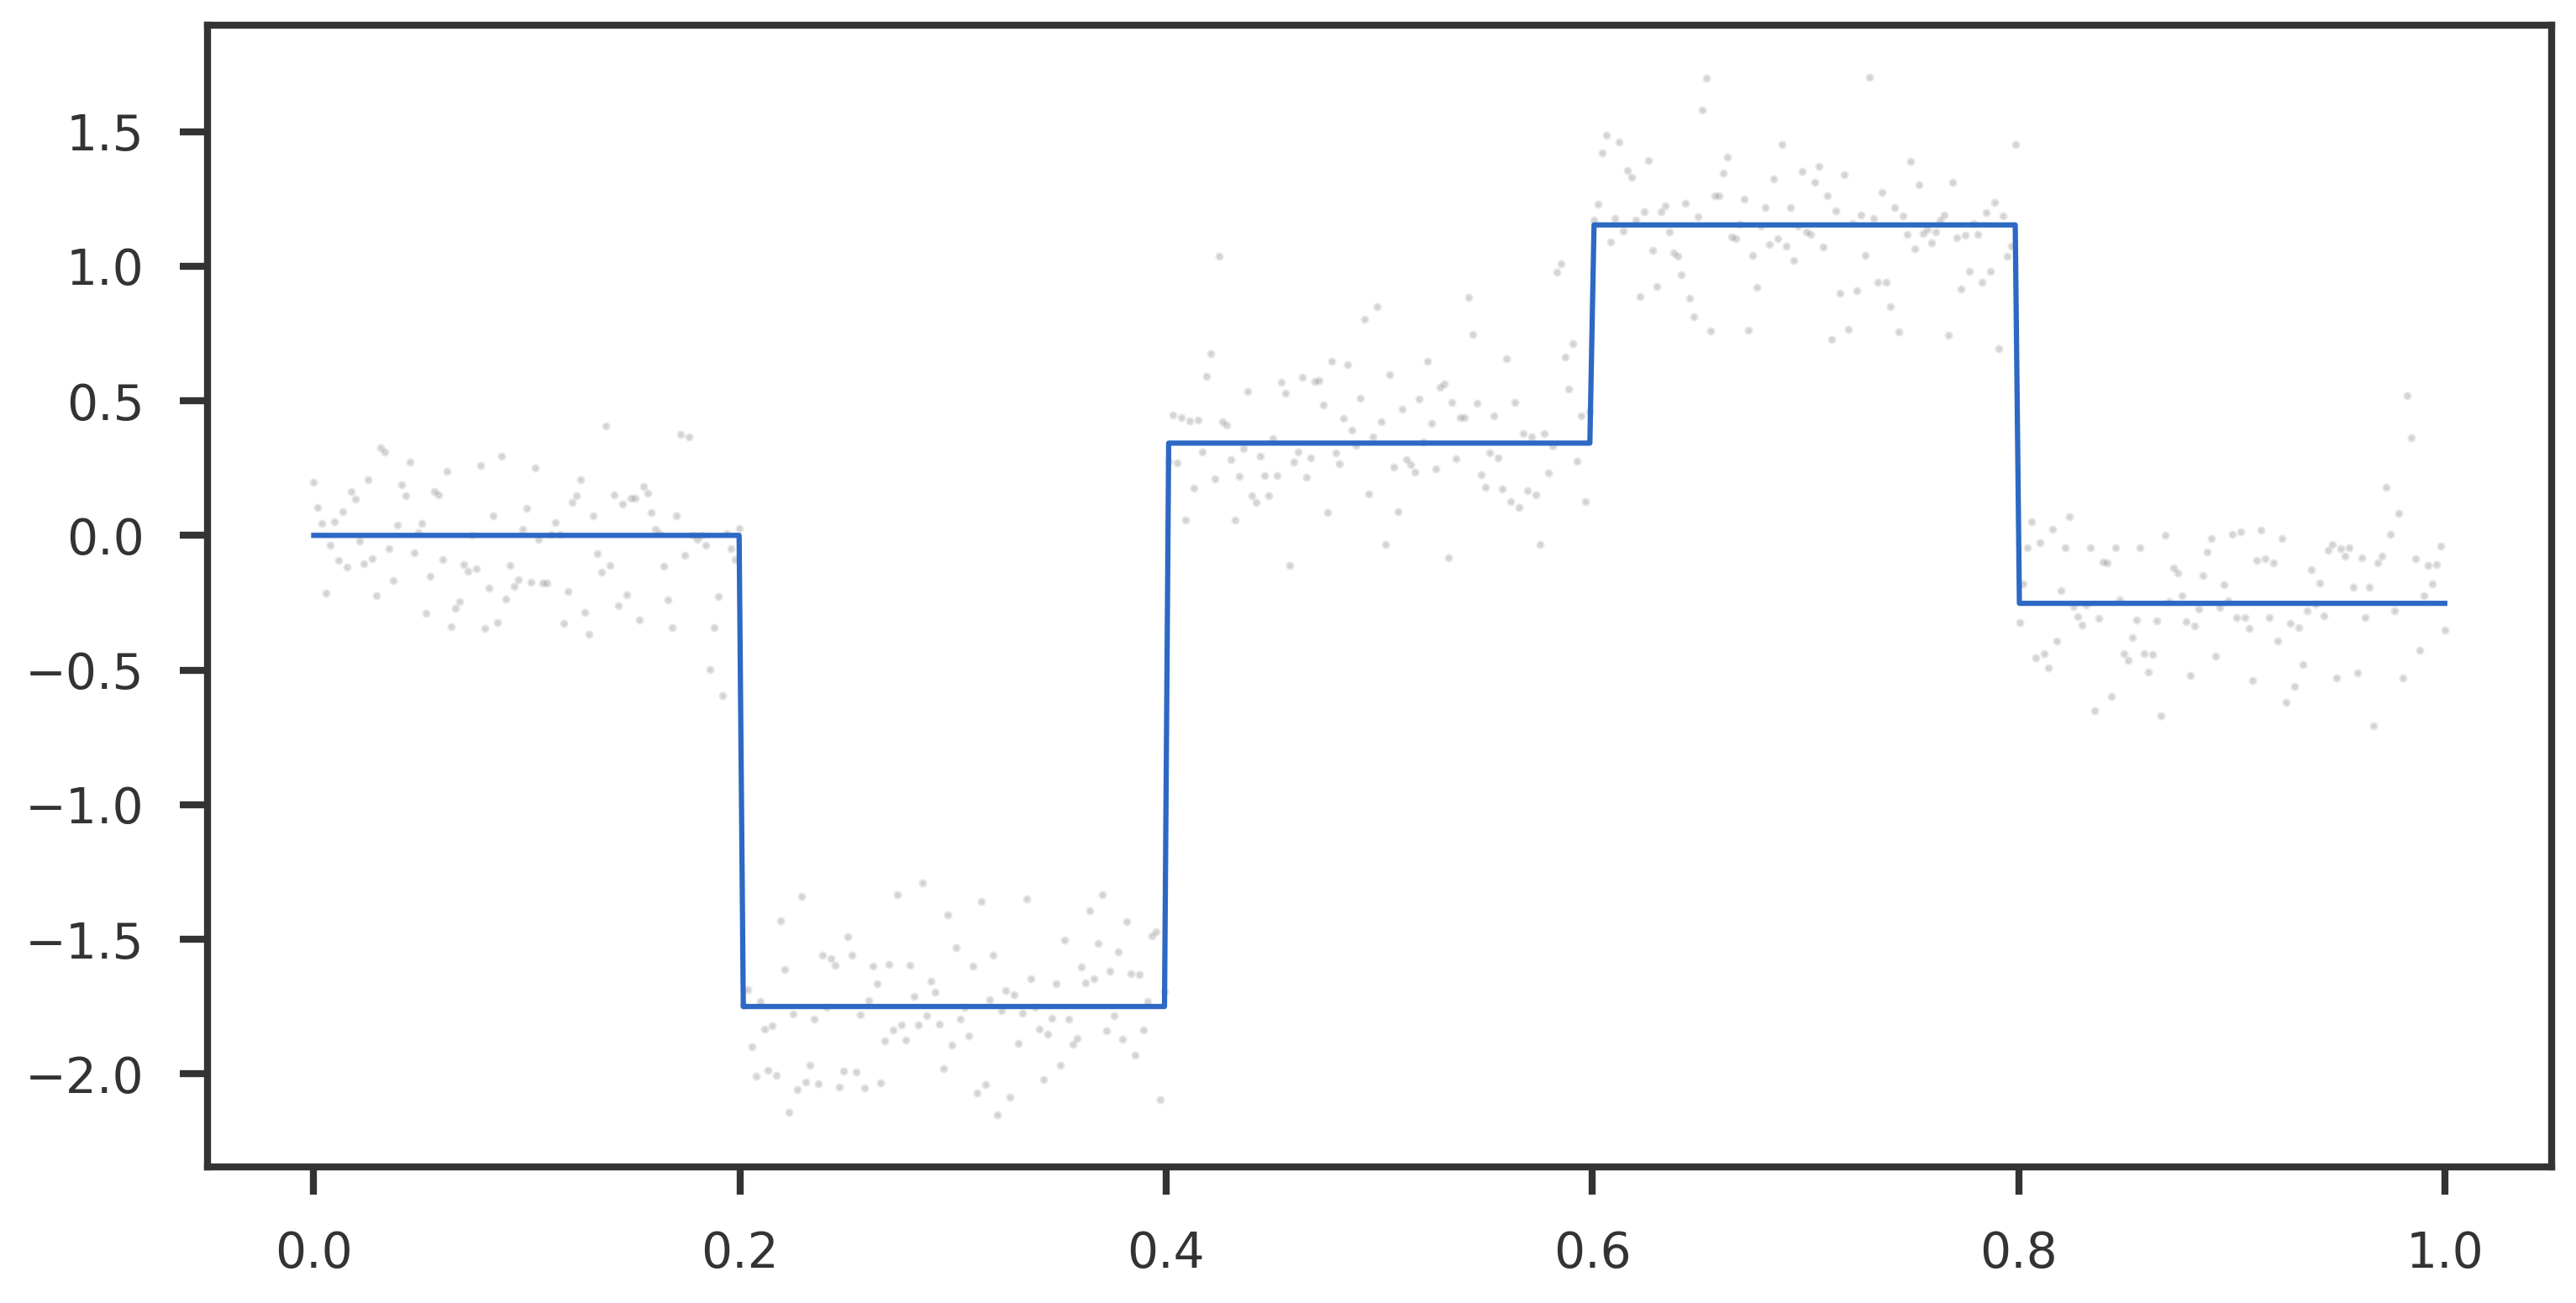

In [3]:
fig = plt.figure(figsize = (12, 6))
ax1 = fig.add_subplot(111)
ax1.scatter(data.x, data.y, s = 2, color = 'grey', alpha = 0.2)
ax1.plot(data.x, data.ytrue)
plt.show()

In [4]:
data.snr

62.95022449884645

In [5]:
signal = np.sum(np.square(np.diff(data.ytrue))) / nknots
noise  = np.var(data.y - data.ytrue)
signal / noise

56.67895700559898

In [6]:
noise

0.04442581714594923

In [7]:
tf_y, tf_fit = R_trendfilter.fit(data.y, order = degree)

R[write to console]: Loading required package: Matrix



Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 



In [18]:
prior_init = toy_priors.get_ash(k = 20, sparsity = 0.99, skbase = 2.0, skfactor = 10.0)
gv1 = Trendfiltering(maxiter = 20000, standardize_basis = False, standardize = False)
#gv1.fit(data.y, degree, prior_init, y_init = tf_y)
gv1.fit(data.y, degree, prior_init)

In [19]:
gv1.niter

1342

In [43]:
gv2 = Trendfiltering(maxiter = 20000, scale_basis = True, standardize = False)
gv2.fit(data.y, degree, prior_init, y_init = tf_y)

In [44]:
gv2.niter

1353

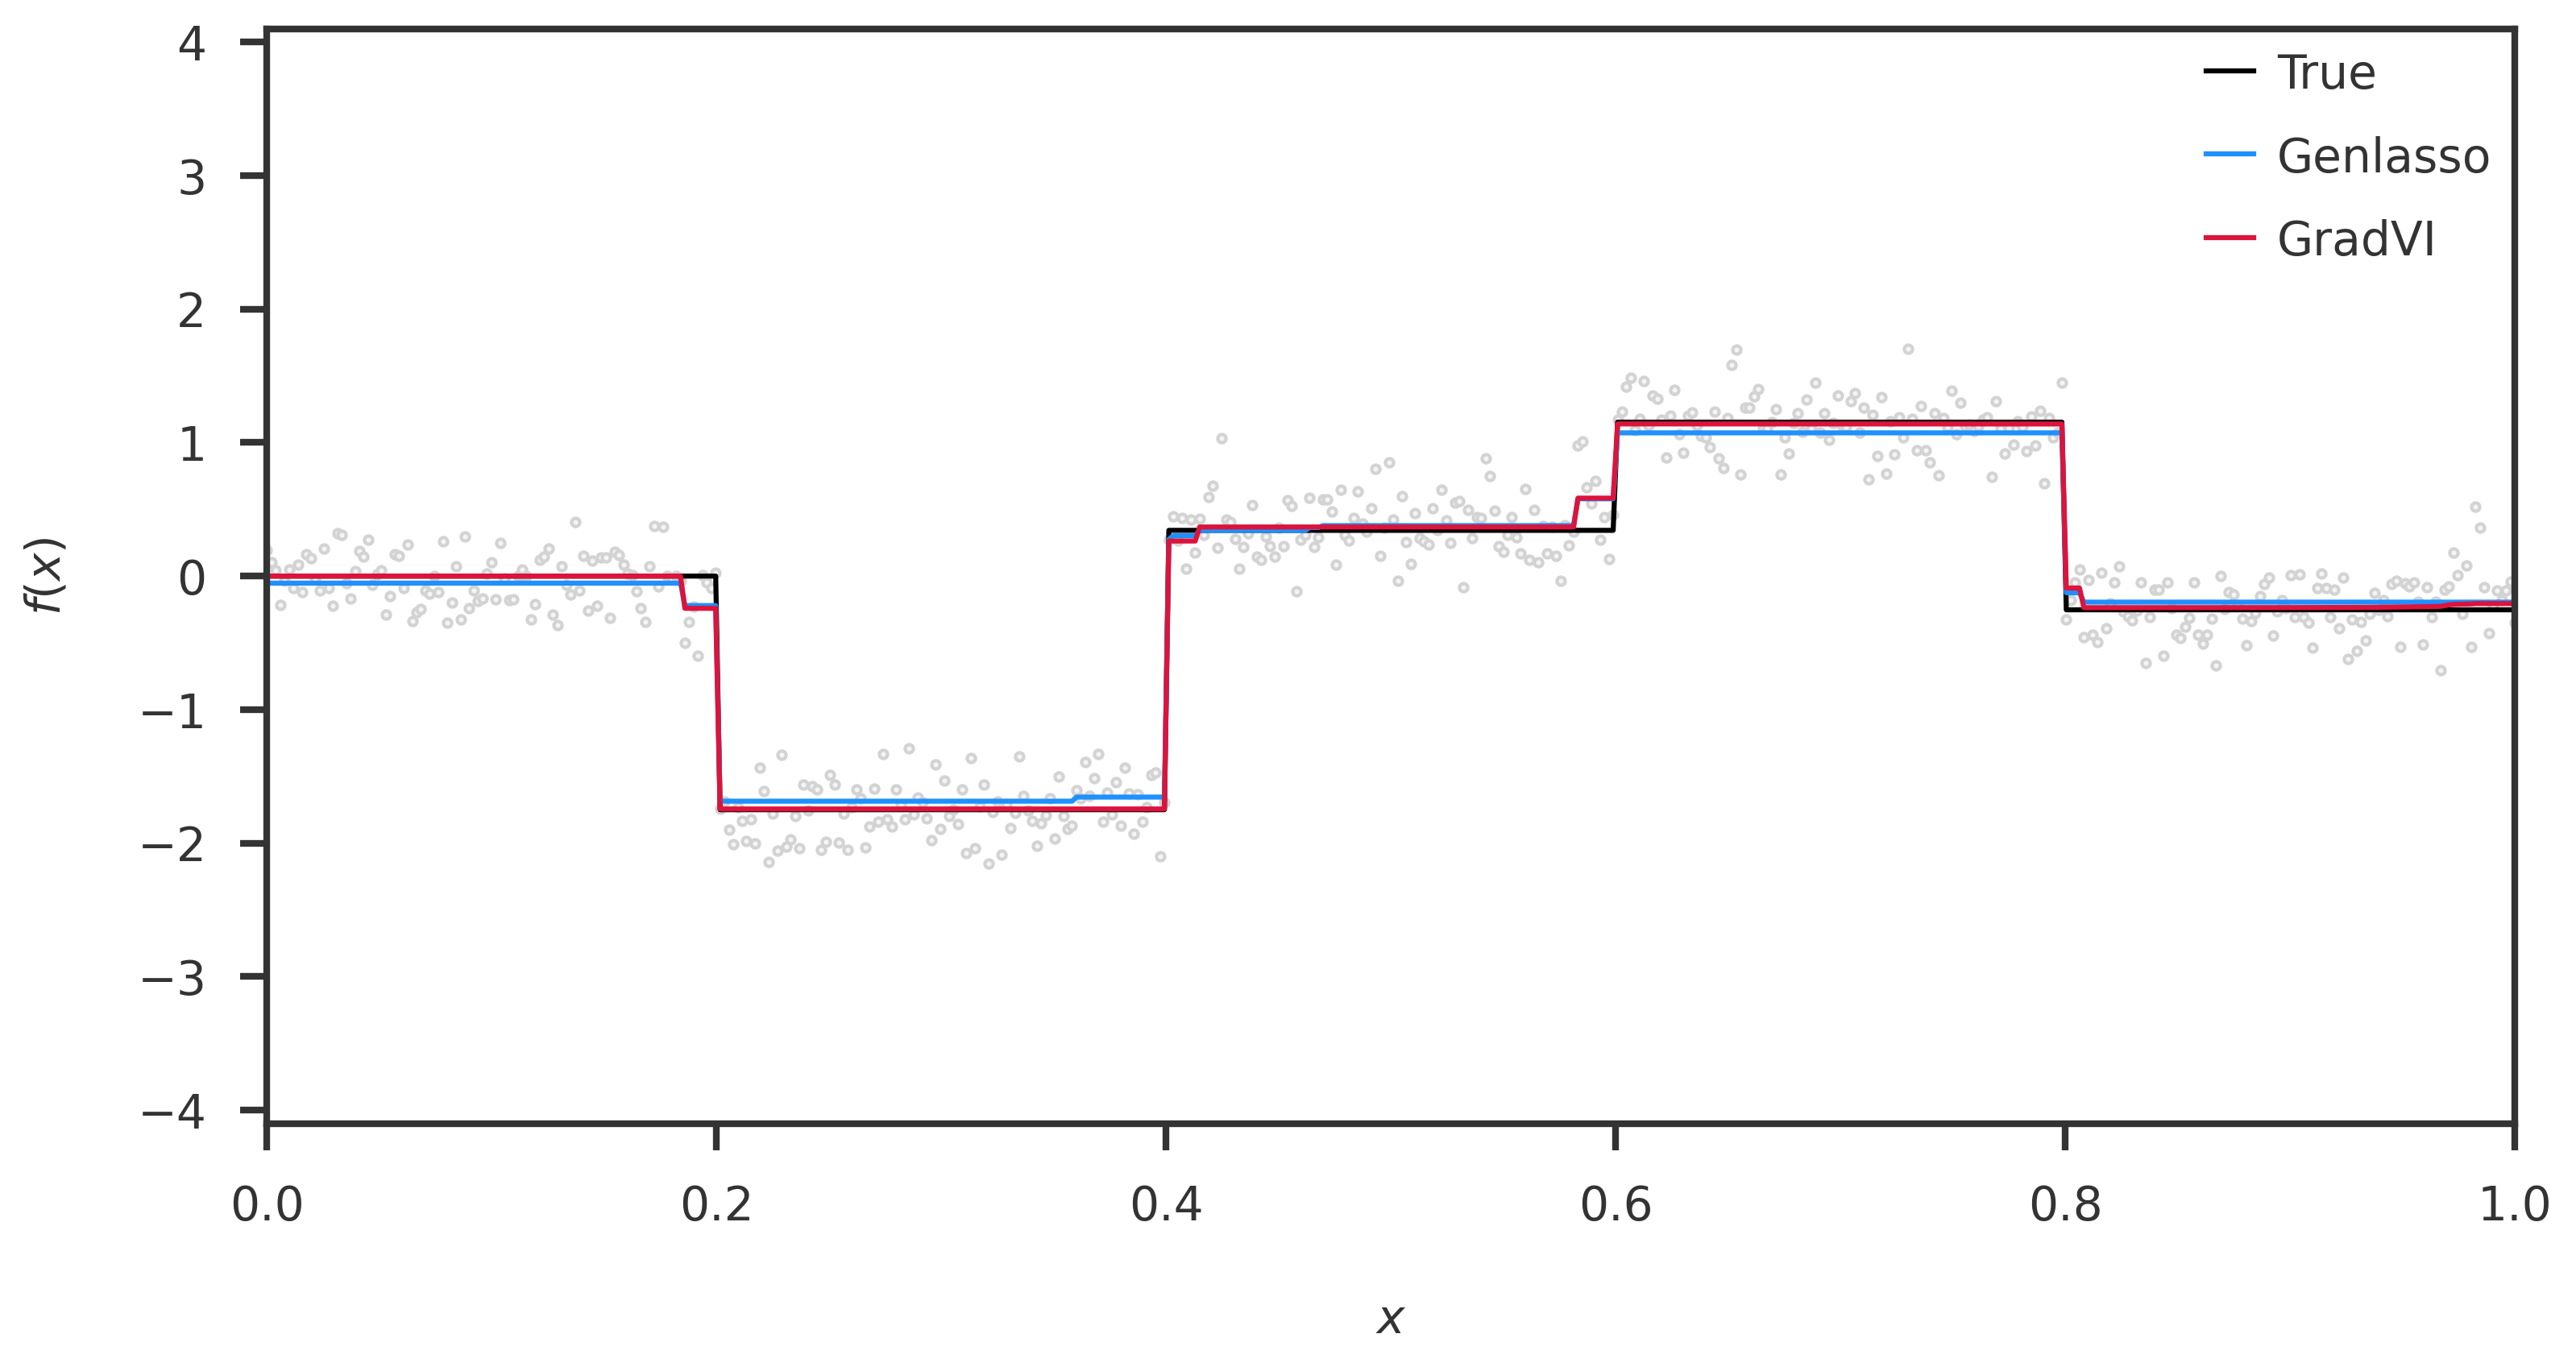

In [45]:
fig = plt.figure(figsize = (12, 6))
ax1 = fig.add_subplot(111)
ax1.scatter(data.x, data.y, s = 6, color = 'lightgrey', marker = 'o', facecolor = 'whitesmoke')
ax1.plot(data.x, data.ytrue, label = 'True', color = 'black')
ax1.plot(data.x, tf_y, label = 'Genlasso', color = 'dodgerblue')
ax1.plot(data.x, gv2.ypred, label = 'GradVI', color = 'crimson')

ax1.set_ylim(-4.1, 4.1)
ax1.set_xlim(0, 1)
ax1.legend()

ax1.set_xlabel(r"$x$")
ax1.set_ylabel(r"$f(x)$")

#fig.savefig("trendfiltering_example_degree0_large_se.pdf", bbox_inches = 'tight')
plt.show()

In [46]:
gv2.prior.w

array([9.83304711e-01, 5.52001566e-13, 2.63280449e-13, 5.32753722e-13,
       1.15187121e-12, 2.16008492e-12, 2.98914248e-12, 3.12905006e-12,
       2.85197099e-12, 2.50183262e-12, 2.18556255e-12, 1.91212609e-12,
       1.69651010e-12, 1.58975199e-12, 1.70355393e-12, 2.38041216e-12,
       5.42075597e-12, 3.01194516e-11, 8.36931824e-10, 1.66952877e-02])

In [48]:
'''
CAVI
'''
ma_y_init = gvma.moving_average(data.y)
mrash_r = MrASHR(option = "r2py", debug = False)
mrash_r.fit(data.H, data.y, prior_init.sk, winit = prior_init.w)#,
            #binit = np.dot(data.Hinv, ma_y_init), winit = prior_init.w)

mrash_ypred = np.dot(data.H, mrash_r.coef) + mrash_r.intercept
mrash_elbo = mrash_r.elbo_path[-1]

Mr.ASH terminated at iteration 294.


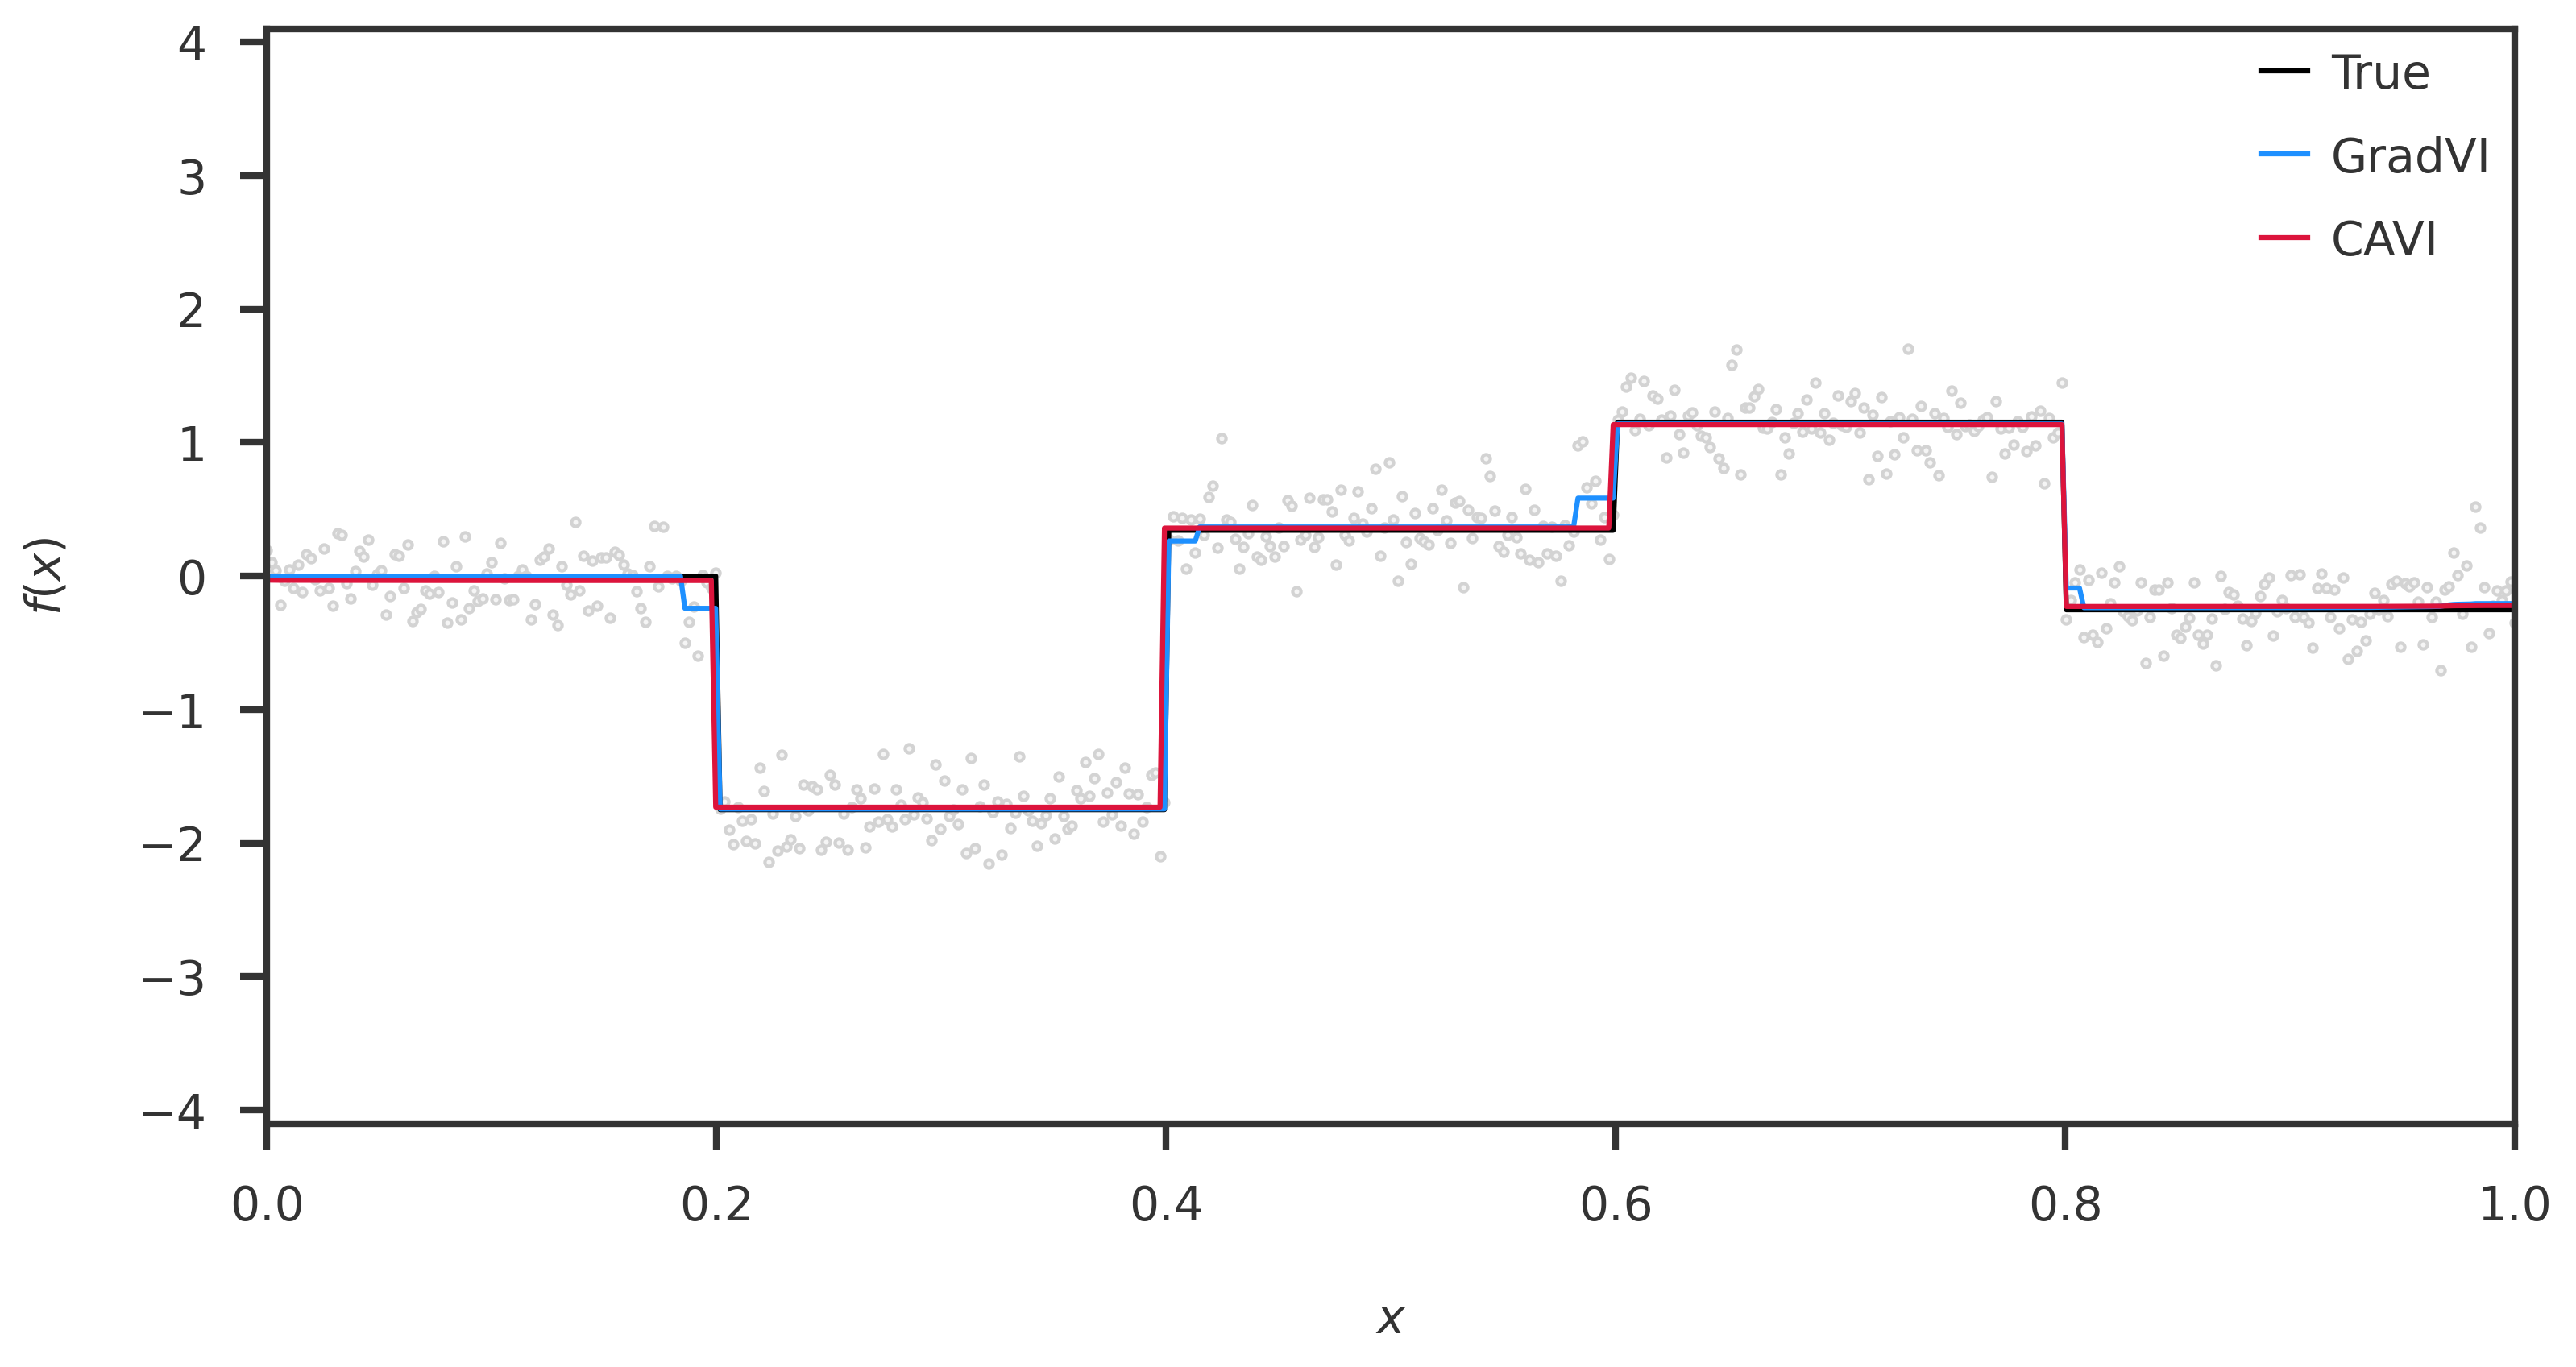

In [49]:
fig = plt.figure(figsize = (12, 6))
ax1 = fig.add_subplot(111)
ax1.scatter(data.x, data.y, s = 6, color = 'lightgrey', marker = 'o', facecolor = 'whitesmoke')
ax1.plot(data.x, data.ytrue, label = 'True', color = 'black')
ax1.plot(data.x, gv2.ypred, label = 'GradVI', color = 'dodgerblue')
ax1.plot(data.x, mrash_ypred, label = 'CAVI', color = 'crimson')

ax1.set_ylim(-4.1, 4.1)
ax1.set_xlim(0, 1)
ax1.legend()

ax1.set_xlabel(r"$x$")
ax1.set_ylabel(r"$f(x)$")
plt.show()

In [36]:
mrash_r.elbo_path

array([542.72715076, 428.32674221, 365.93154944, 338.79429453,
       322.13019211, 308.66510893, 291.94998415, 272.7376959 ,
       250.87906487, 227.14989945, 211.31707012, 195.81833545,
       181.89554317, 169.86260397, 159.27167613, 148.76649144,
       143.7587499 , 140.33748151, 137.679702  , 135.15075762,
       132.51745338, 129.9108445 , 127.43030701, 123.75445418,
       119.65463644, 117.40122422, 115.71870647, 114.13439816,
       112.50453734, 110.85195692, 108.64695168, 101.31849209,
        99.7396565 ,  98.31518864,  96.99719048,  95.77709646,
        94.63057138,  92.47117134,  83.42216492,  77.36978931,
        72.34207633,  71.33805834,  70.48279735,  69.70489105,
        68.99083719,  68.3312184 ,  67.71848201,  67.14606959,
        66.60575995,  66.079236  ,  65.48043687,  63.59561865,
        57.20819519,  56.56481856,  56.23100849,  55.91458614,
        55.61426506,  55.33094349,  55.06464304,  54.81479966,
        54.58060779,  54.36115538,  54.15550109,  53.96

In [38]:
gv2.elbo_path

array([ 44.05533795,  42.87775239,  41.23177942, ..., -19.59242354,
       -19.5924281 , -19.59242869])